In [1]:
import os
import copy
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from tdc.multi_pred import DTI
import pickle
from sklearn.model_selection import train_test_split

from data_preparation import partition_data_by_continious_var, evaluate_partitioning

In [ ]:
#make data dir 
data_dir = Path('./data')
data_dir.mkdir(exist_ok=True)

data_kiba = DTI(name = 'KIBA', path=data_dir)

In [3]:
data_kiba = DTI(name = 'KIBA', path=data_dir)

Found local copy...
Loading...
Done!


In [4]:
df_kiba = data_kiba.get_data() 

In [5]:
df_kiba.head() #Smaller KIBA values (Y) - higher binding affinity

,Drug_ID,Drug,Target_ID,Target,Y
0,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O00141,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.1
1,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O14920,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.1
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O15111,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.1
3,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,11.1
4,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P04626,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.1


The data point should have a numerical characteristic, e.g affinity, in our case it's KIBA value stored in column Y. We will look to the distribution of these value and based on it separate three chunks of data: Biners, Weak binders and Non-binders. Alternatively Weak and  Non-binders dataset can be constructed based on their structural/sequence similarity but those we can label as negative class. So Weak binders should be more similar to Binders than Non-binders to Binders. 

Below is the code which helped us to decide which targets to take from KIBA datset. The selection criteria were: dataset size, the possibility to divide target specific data into three approximately equal partitions (Binder, Weak, Non-binder)

In [ ]:
#let's take the Targets that have the most drugs associated with them
targets_subset = df_kiba.groupby('Target_ID').count().sort_values('Drug_ID', ascending=False).iloc[:30].index
df_kiba_selected = df_kiba[df_kiba['Target_ID'].isin(selected_targets)]

In [ ]:
#Divide target specific data into Binder, Weak and Non-binder equel particians collect statistics
df_class_counts = pd.DataFrame(columns=['Target_ID', 'Binder bin size', 'Weak bin size', 'Non-binder bin size', 'Largest bin size ratio','Ideal bin size','Binder threashold', 'Weak threashold'])

for i, target in enumerate(targets_subset):
    df_processed, binder_thr, weak_thr = partition_data_by_continious_var(df_kiba_selected.query(f'Target_ID == "{target}"'), 'Y')
    n, n_binder, n_weak, n_non_binder, class_ratio, n_fair = evaluate_partitioning(df_processed, verbose=False)
    df_class_counts.loc[i] = [target, n_binder, n_weak, n_non_binder, class_ratio, n_fair, binder_thr, weak_thr]

In [13]:
df_class_counts.sort_values('Largest bin size ratio', ascending=True).head(10)

,Target_ID,Binder bin size,Weak bin size,Non-binder bin size,Largest bin size ratio,Ideal bin size,Binder threashold,Weak threashold
19,Q96GD4,349,327,330,1.067073,335,11.3,12.100000
3,P49841,420,373,375,1.125668,389,11.3,11.999998
18,Q13627,369,311,330,1.185897,336,11.3,11.900001
4,P06239,379,416,340,1.222874,378,11.6,11.699999
21,Q13464,372,299,329,1.243333,333,11.1,11.999998
8,P11309,421,335,334,1.259701,363,11.1,11.500000
2,O94806,491,329,383,1.490909,401,11.1,11.600000
27,P49840,384,254,316,1.509804,318,11.2,11.699999
22,P51812,407,266,314,1.528090,329,11.2,11.600000
0,P35968,612,342,478,1.787172,477,11.2,12.010095


In [ ]:
#we select targets with the largest bin size ratio less than 1.5
selected_targets = df_class_counts[df_class_counts["Largest bin size ratio"] < 1.5].Target_ID.values
selected_targets

array(['O94806', 'P49841', 'P06239', 'P11309', 'Q13627', 'Q96GD4',
       'Q13464'], dtype=object)

In [22]:
#mkdir KIBA_selected
kiba_dir = data_dir.joinpath('KIBA_selected')
kiba_dir.mkdir(exist_ok=True, parents=True)

for target in selected_targets:
    df = df_kiba_selected.query('Target_ID == @target')
    df.to_csv(kiba_dir / f'{target}_KIBA.csv', index=False)


In [20]:
def kiba_label_target(target_df):
    """Helper function to estimate the sizes of Biners, Weak binders and Non-binders partitions
      in case we separate data almost equally into 3"""
    n = target_df.shape[0]//3
    processed_df = target_df.sort_values('Y', ascending=True)
    binder_thr= processed_df.iloc[n-1].Y
    weak_thr = processed_df.iloc[2*n-1].Y
    processed_df['Class'] = processed_df.Y.apply(lambda x: 'Binder' if x <= binder_thr else 'Weak' if x <= weak_thr else 'Non-binder')
    return processed_df, binder_thr, weak_thr


In [21]:
#Create a folder to store the processed data
processed_data_path = data_dir.joinpath('processed')
processed_data_path.mkdir(parents=True, exist_ok=True)
processed_data_path.joinpath('initial_division_by_binding_class').mkdir(exist_ok=True)

#Divide target specific data into Binder, Weak and Non-binder equel particians collect statistics
df_class_counts = pd.DataFrame(columns=['Target_ID', 'Binder', 'Weak', 'Non-binder', 'binder_thr', 'weak_thr', 'mode', 'mode_count'])
for i, target in enumerate(selected_targets):
    df_processed, binder_thr, weak_thr = kiba_label_target(df_kiba_selected.query(f'Target_ID == "{target}"'))
    counts= df_processed['Class'].value_counts().to_dict()
    
    # the bellow statistics is calculated to see where the most spike of KIBA value is
    target_mode = df_processed['Y'].mode()[0]
    mode_count = df_processed['Y'].value_counts().max()

    df_class_counts.loc[i] = [target, counts.get('Binder', 0), counts.get('Weak', 0), counts.get('Non-binder', 0),  binder_thr, weak_thr, target_mode, mode_count]
    df_processed.to_csv( processed_data_path / f'initial_division_by_binding_class/{target}_by_class.csv')

In [22]:
# statistics calculated to select target where 'Binder', 'Weak', 'Non-binder' particians are almost equal
df_class_counts['Imbalance'] = df_class_counts[['Binder', 'Weak', 'Non-binder']].apply(lambda x: (x.max() / (x.min()+1)), axis=1)
df_class_counts["n_fair"] = df_class_counts[['Binder', 'Weak', 'Non-binder']].sum(axis=1)/3
df_class_counts["n"] = df_class_counts[['Binder', 'Weak', 'Non-binder']].sum(axis=1)

In [23]:
df_class_counts.sort_values('Imbalance', ascending=True, inplace=True)
df_class_counts.reset_index(inplace=True)
df_class_counts.head(10)

,index,Target_ID,Binder,Weak,Non-binder,binder_thr,weak_thr,mode,mode_count,Imbalance,n_fair,n
0,19,Q96GD4,349,327,330,11.3,12.100000,11.300000,250,1.064024,335.333333,1006
1,3,P49841,420,373,375,11.3,11.999998,11.300000,268,1.122995,389.333333,1168
2,18,Q13627,369,311,330,11.3,11.900001,11.300000,294,1.182692,336.666667,1010
3,4,P06239,379,416,340,11.6,11.699999,11.699999,406,1.219941,378.333333,1135
4,21,Q13464,372,299,329,11.1,11.999998,11.100000,332,1.240000,333.333333,1000
5,8,P11309,421,335,334,11.1,11.500000,11.100000,358,1.256716,363.333333,1090
6,2,O94806,491,329,383,11.1,11.600000,11.100000,256,1.487879,401.000000,1203
7,27,P49840,384,254,316,11.2,11.699999,11.200000,327,1.505882,318.000000,954
8,22,P51812,407,266,314,11.2,11.600000,11.200000,360,1.524345,329.000000,987
9,0,P35968,612,342,478,11.2,12.010095,11.200000,348,1.784257,477.333333,1432


In [ ]:
targets_balanced_list = df_class_counts.iloc[:6].Target_ID # Imbalance < 1.5

In [30]:
targets_balanced_list.values

array(['Q96GD4', 'P49841', 'Q13627', 'P06239', 'Q13464', 'P11309'],
      dtype=object)

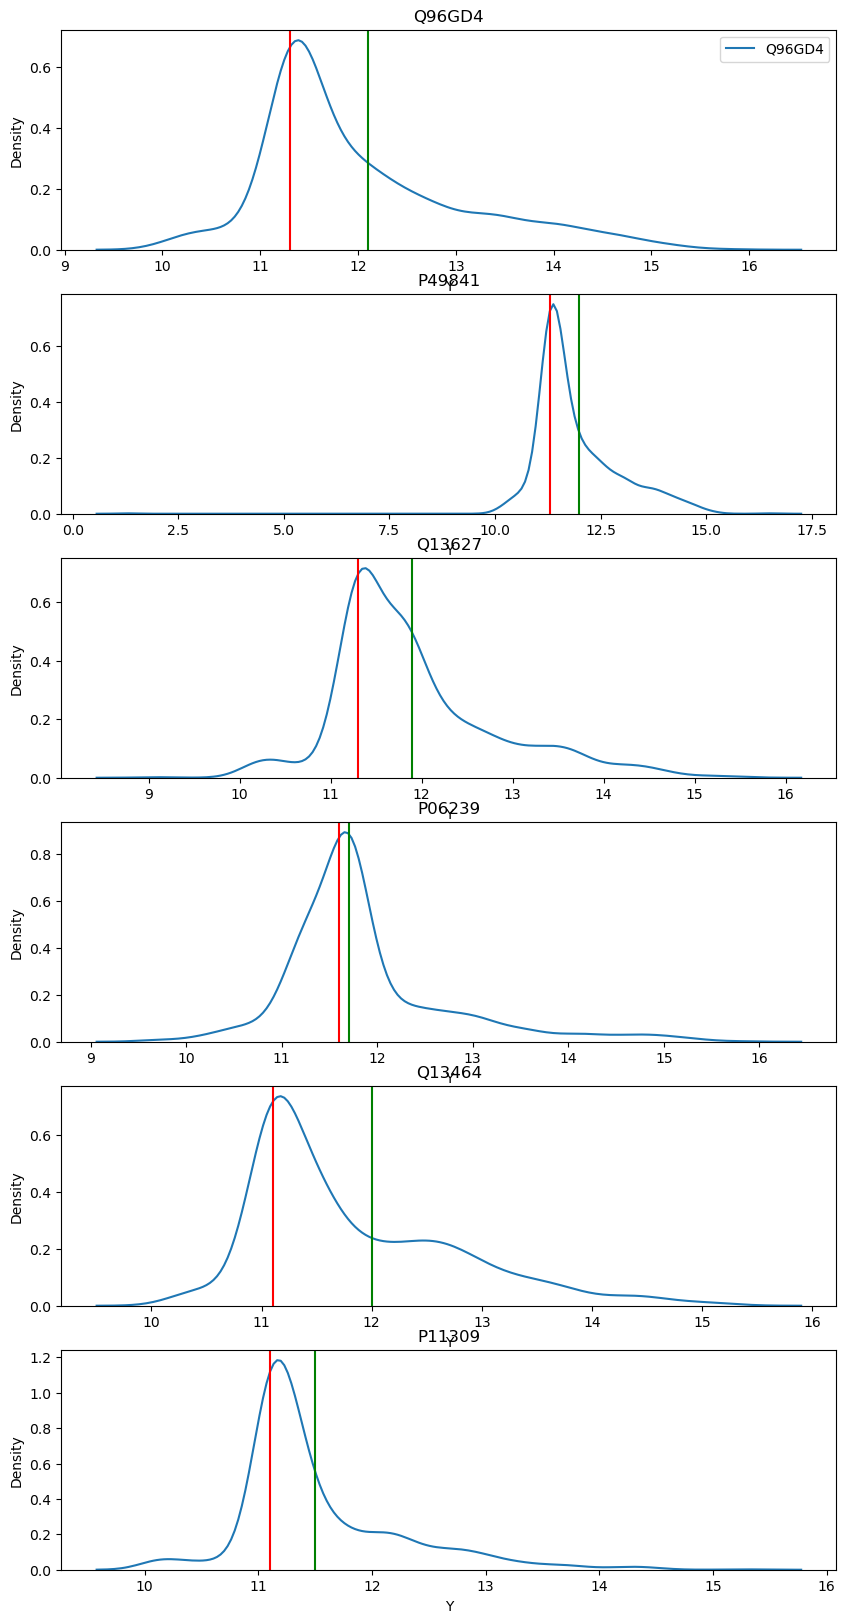

In [ ]:
#visualize the distribution of KIBA values for each target and the thresholds for data partitioning
fig, ax = plt.subplots(6, figsize = (10,20))
for i, target in enumerate(targets_balanced_list):
    sns.kdeplot(df_kiba_selected.query(f'Target_ID == "{target}"')['Y'], label=target, ax=ax[i])
    ax[i].axvline(df_class_counts.query(f'Target_ID == "{target}"')['binder_thr'].values[0], color='red')
    ax[i].axvline(df_class_counts.query(f'Target_ID == "{target}"')['weak_thr'].values[0], color='green')
    ax[i].set_title(target)
fig.savefig('./figures/target_kiba_thresholds.png')

100
100
100
100
100
100


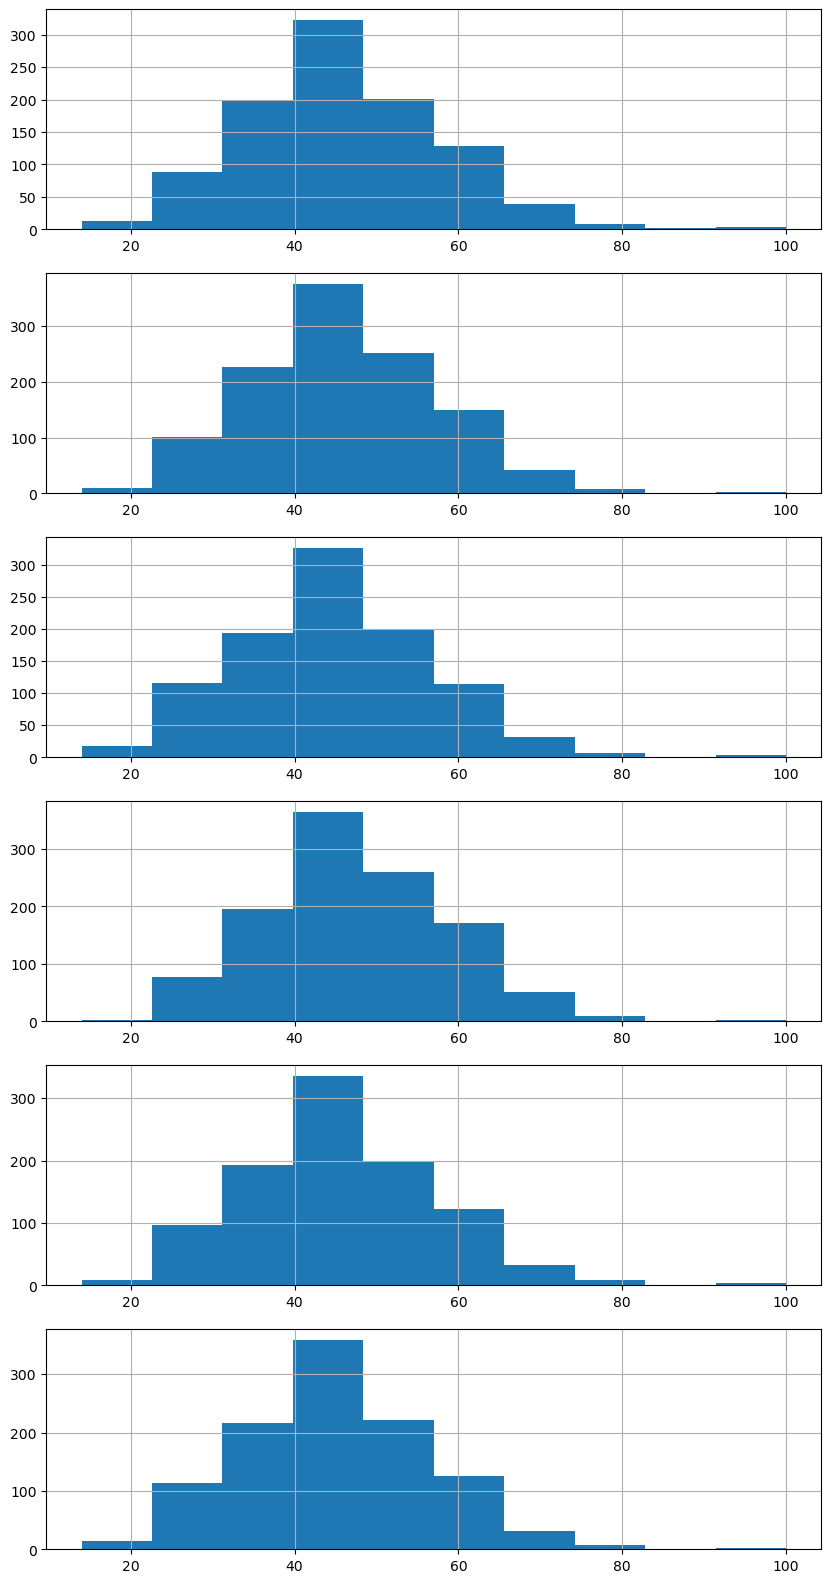

In [40]:
fig, ax = plt.subplots(6, figsize = (10,20))
for i, target in enumerate(targets_balanced_list):
    smiles_len = df_kiba_selected.query(f'Target_ID == "{target}"')['Drug'].apply(len)
    smiles_len.hist(ax=ax[i])
    print(smiles_len.max())

In [41]:
#also it is interesting if those drugs overlab between targets. I will do upset plot here

In [ ]:

SMISET = {"C": 67, "l": 1, ".": 2, "c": 3, "1": 4, "2": 5, "(": 6,
          "N": 7, "=": 8, "3": 9, ")": 10, "n": 11, "[": 12, "H": 13,
           "]": 14, "O": 15, "@": 16, "s": 17, "+": 18, "/": 19, "S": 20,
            "F": 21, "-": 22, "4": 23, "B": 24, "r": 25, "o": 26, "\\": 27,
             "#": 28, "5": 29, "a": 30, "P": 31, "e": 32, "6": 33, "7": 34,
              "I": 35, "A": 36, "i": 37, "8": 38, "9": 39, "Z": 40, "K": 41,
               "L": 42, "%": 43, "0": 44, "T": 45, "g": 46, "G": 47, "d": 48,
                "M": 49, "b": 50, "u": 51, "t": 52, "R": 53, "p": 54, "m": 55,
                 "W": 56, "Y": 57, "V": 58, "~": 59, "U": 60, "E": 61, "f": 62,
                  "X": 63, "D": 64, "y": 65, "h": 66}

def one_hot_smiles(line, MAX_SMI_LEN=100):
    """
    Converts a SMILES string into a one-hot encoded tensor. If smile is shorter than MAX_SMI_LEN, it is padded with zeros.
    """
    X = np.zeros((MAX_SMI_LEN, len(SMISET))) # +1 

    if type(line)!=str:
        print('SMILE format is not str!')
    for i, ch in enumerate(line[:MAX_SMI_LEN]):
        tmp=SMISET.get(ch)
        if tmp:
            X[i, tmp - 1] = 1
        else:
            print(line,'exits not in SMISET character',ch)
    X = X.tolist()
    X = np.array(X).flatten() 
    return X

In [43]:
#all binders by Tardet_ID
list_dfs = []
for target in selected_targets:
    df = pd.read_csv(f'./data/processed/initial_division_by_binding_class/{target}_by_class.csv')
    df = df.query("Class == 'Binder'")
    df["Target"] = target
    list_dfs.append(df)
df_all_binders = pd.concat(list_dfs).sample(frac=1, random_state=42)

In [44]:
def create_tasks(target, random_state=42):
    df = pd.read_csv(f'./data/processed/initial_division_by_binding_class/{target}_by_class.csv')
    n_smallest = df["Class"].value_counts().min()
    
    def process_class(subset, y_binary):
        subset["Y_binary"] = y_binary
        subset["X"] = subset['Drug'].apply(one_hot_smiles)
        return subset
    
    binder = df.query('Class == "Binder"').sample(n=n_smallest, random_state=random_state)
    binder = process_class(binder, 1)
    
    weak = df.query('Class == "Weak"').sample(n=n_smallest, random_state=random_state)
    weak = process_class(weak, 0)
    
    non_binder = df.query('Class == "Non-binder"').sample(n=n_smallest, random_state=random_state)
    non_binder = process_class(non_binder, 0)
    
    vs_all = df_all_binders.query(f'Target != "{target}"')
    vs_all = vs_all[~vs_all['Drug'].isin(binder['Drug'])].sample(n=n_smallest, random_state=random_state)
    vs_all = process_class(vs_all, 0)

    df_vs_weak = pd.concat([binder, weak]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    df_vs_non_binder = pd.concat([binder, non_binder]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    df_vs_all = pd.concat([binder, vs_all]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    df_shuffled_weak = copy.deepcopy(df_vs_weak)
    df_shuffled_weak["Y_binary"] = df_shuffled_weak["Y_binary"].sample(frac=1, random_state=random_state).reset_index(drop=True)

    return df_vs_weak, df_vs_non_binder, df_vs_all, df_shuffled_weak

In [45]:
for target in targets_balanced_list:
        df_vs_weak, df_vs_non_binder, df_vs_all, df_shuffled_weak= create_tasks(target)
        
        os.makedirs(f'./data/processed/{target}/', exist_ok=True)

        df_vs_weak.to_pickle(f'./data/processed/{target}/{target}_vs_weak.pkl')
        df_vs_non_binder.to_pickle(f'./data/processed/{target}/{target}_vs_non_binder.pkl')
        df_vs_all.to_pickle(f'./data/processed/{target}/{target}_vs_all.pkl')
        df_shuffled_weak.to_pickle(f'./data/processed/{target}/{target}_shuffled_weak.pkl')


In [46]:
def save_splits(df, target, path, splits):
    for split in splits:
        split_path = Path(path) / f'split_{split}'
        split_path.mkdir(parents=True, exist_ok=True)
        
        df_train, df_test = train_test_split(df, test_size=0.2, random_state=split)
        # Save as pickle
        df_train.to_pickle(split_path / 'train.pkl')
        df_test.to_pickle(split_path / 'test.pkl')

# For each target in targets_balanced_list, create different splits in terms of random seed and save them
splits = [0, 1, 2, 42]
for target in targets_balanced_list:
    path_to_target = Path('./data/processed') / target
    # Read from pickle
    df_vs_weak = pd.read_pickle(path_to_target / f'{target}_vs_weak.pkl')
    df_vs_non_binder = pd.read_pickle(path_to_target / f'{target}_vs_non_binder.pkl')
    df_vs_all = pd.read_pickle(path_to_target / f'{target}_vs_all.pkl')
    df_shuffled_weak = pd.read_pickle(path_to_target / f'{target}_shuffled_weak.pkl')
    
    path_vs_weak = path_to_target / 'vs_Weak'
    path_vs_non_binder = path_to_target / 'vs_Non-binder'
    path_vs_all = path_to_target / 'vs_all'
    path_shuffled_weak = path_to_target / 'shuffled_weak'
    
    path_vs_weak.mkdir(parents=True, exist_ok=True)
    path_vs_non_binder.mkdir(parents=True, exist_ok=True)
    path_vs_all.mkdir(parents=True, exist_ok=True)
    path_shuffled_weak.mkdir(parents=True, exist_ok=True)
    
    save_splits(df_vs_weak, target, path_vs_weak, splits)
    save_splits(df_vs_non_binder, target, path_vs_non_binder, splits)
    save_splits(df_vs_all, target, path_vs_all, splits)
    save_splits(df_shuffled_weak, target, path_shuffled_weak, splits)

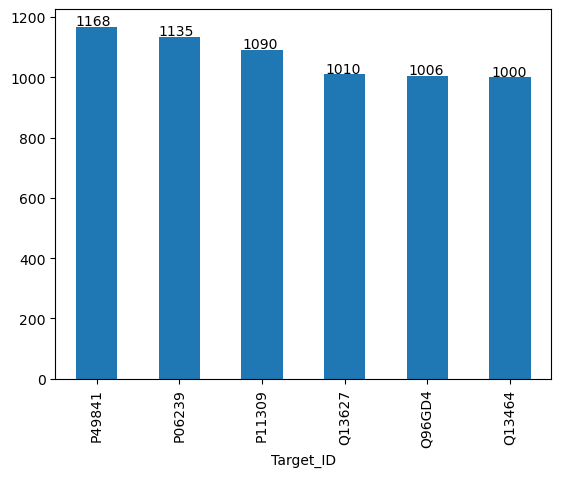

In [47]:
#Accumulate statistics
ax = df_kiba_selected.query('Target_ID in @targets_balanced_list').groupby('Target_ID').count().sort_values('Drug_ID', ascending=False).Drug_ID.plot(kind='bar')

# Add numbers on top of the bar plots
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))



In [48]:
sorted_targets = df_kiba_selected.query('Target_ID in @targets_balanced_list').groupby('Target_ID').count().sort_values('Drug_ID', ascending=False).index.to_list()

In [49]:
#how many smiles do we have per target in train and test
n_smiles = []
for target in sorted_targets:
    train_size = len(pd.read_pickle(f'./data/processed/{target}/vs_Weak/split_0/train.pkl'))
    test_size = len(pd.read_pickle(f'./data/processed/{target}/vs_Weak/split_0/test.pkl'))
    n_smiles.append([target, train_size, test_size])  
df_train_test_size = pd.DataFrame(n_smiles, columns=['Target', 'Train size', 'Test size'])


In [50]:
df_train_test_size.to_csv('./data/processed/train_test_size.csv')

11.300000237 11.303734096
11.300000237 11.331801867
11.300000237 11.35000022
11.599999785 11.637602002
11.1 11.120240812
11.1 11.118106086


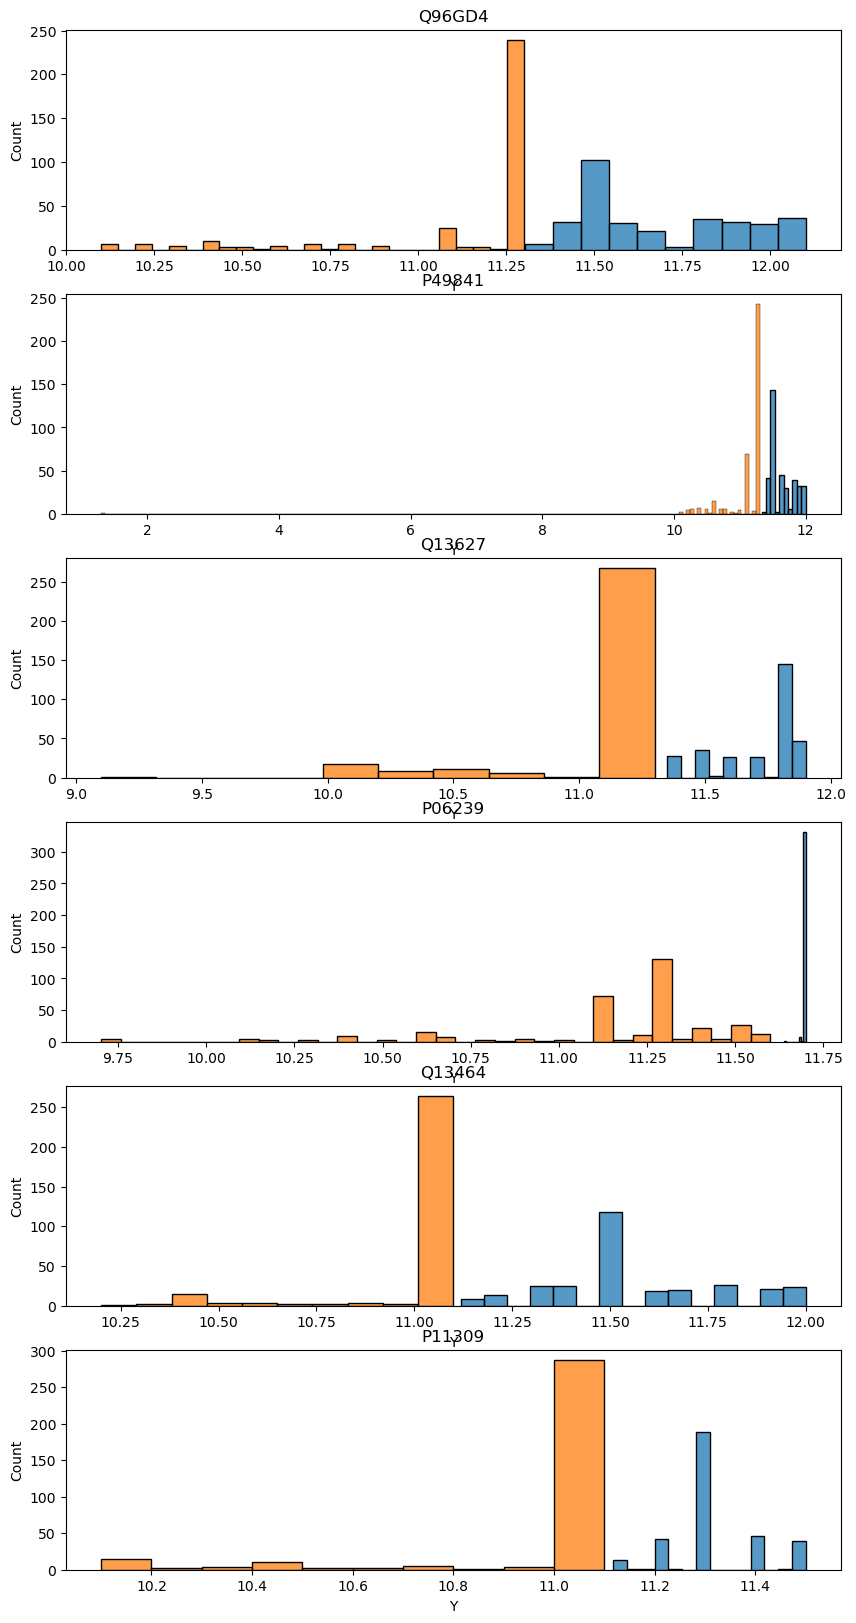

In [51]:
## why vs_Weak behaves as randomized daatset. I can overlay binding energy distributions of positive and negative samples i it
fig, ax = plt.subplots(6, figsize = (10,20))
for i, target in enumerate(targets_balanced_list):
    df_positive = pd.read_pickle(f'./data/processed/{target}/{target}_vs_weak.pkl').query('Y_binary == 1')
    df_negative = pd.read_pickle(f'./data/processed/{target}/{target}_vs_weak.pkl').query('Y_binary == 0')
    sns.histplot(df_negative['Y'], label='Weak', ax=ax[i])
    sns.histplot(df_positive['Y'], label='Binder', ax=ax[i])
    ax[i].set_title(target)
    print(df_positive["Y"].max(),df_negative["Y"].min())

In [52]:
test_task = 'vs_Weak'
split= 42
path_to_target = Path('./data/processed') / target
path_vs_task_split = path_to_target / test_task / f'split_{split}'
path_to_test = path_vs_task_split / 'train.pkl'
pd.read_pickle(path_to_test)

,Unnamed: 0,Drug_ID,Drug,Target_ID,Target,Y,Class,Y_binary,X
235,45504,CHEMBL1994538,O=C(Nc1cnccn1)Nc1ccnc2c(C(F)(F)F)cccc12,P11309,MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASR...,11.2,Weak,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
399,37666,CHEMBL1988153,Cc1nnc(-c2cc3c(Oc4ccc(C(F)(F)F)cc4)cncc3s2)o1,P11309,MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASR...,11.5,Weak,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
602,105775,CHEMBL1984847,CC(=O)OCCn1[nH]c(-c2cccc(Br)c2)c2c(C(F)(F)F)cc...,P11309,MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASR...,11.3,Weak,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61,80811,CHEMBL1972365,Nc1cc2nc(-c3ccccc3)cn2cn1,P11309,MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASR...,10.1,Binder,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
145,60221,CHEMBL2006778,CNC(=O)C=Cc1cnc(N)c2c(-c3cc(F)c4[nH]c(C)cc4c3)...,P11309,MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASR...,11.4,Weak,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
71,77769,CHEMBL379835,Cc1nn(-c2ccccc2)c2c1c(=O)c1cc(Cl)ccc1n2O,P11309,MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASR...,11.1,Binder,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
106,59724,CHEMBL2006263,Cc1nc2ccc(NS(=O)(=O)c3ccc(N)cc3)cc2nc1C,P11309,MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASR...,11.2,Weak,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
270,80927,CHEMBL1972820,O=C(O)c1ccc(N2C(=O)c3ccccc3C2=O)cc1O,P11309,MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASR...,11.1,Binder,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
435,110145,CHEMBL518060,Cc1ccc(O)cc1CCC1C(=O)CCC2(C)C(C(C)C=CCC(C)C)CCC12,P11309,MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASR...,10.1,Binder,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
